In [2]:
import copy
import os
import yaml
import re

from multiprocessing import Pool

import numpy as np
import pandas as pd
import geopandas as gpd
import pypsa
import SALib
from SALib.analyze import pawn

import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
from cartopy.io import shapereader
import searoute as sr

# Render matplotlib plots as svg when inline in notebook
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [3]:
MWh_per_tH2 = 33
inflation = 1.2723
cm = 1 / 2.54

ticksize = 8
labelsize = 8
titlesize = 9

config = "regional-variation"

with open("../config/config.default.yaml", "r") as f:
    default_config = yaml.safe_load(f)

with open(f"../results/{config}/config.yaml", "r") as f:
    config_dict = yaml.safe_load(f)

save_figs = True

In [4]:
S = config_dict["scenario"]
net_names = [
    f"elec_s{S['simpl'][0]}_{S['clusters'][0]}_l{S['ll'][0]}__{sector_opts}_{S['planning_horizons'][0]}.nc"
    for sector_opts in S["sector_opts"]
]

def load_net(f):
    return f, pypsa.Network(f)

nets = {}
# Collect all files in nets_dir ending with .nc
nets_dir = f"../results/{config}/param_sweep"
net_files = [f for f in os.listdir(nets_dir) if f.endswith(".nc")]

# Load networks in parallel, use map_async
with Pool(40) as pool:
    for net_file, net in pool.map_async(
        load_net, [os.path.join(nets_dir, f) for f in net_files]
    ).get():
        nets[net_file] = net

INFO:pypsa.io:Imported network elec_s60_20_lc1.1__1000SEG-T-H-B-I-A-Co2L0.45-EXPORT2-LIM+SOUTH+80-onwind+c0.86-offwindfixed+c1.08-offwindfloat+c0.82-SMR CC+c1.03-gas+m1.16-co2 stored+c1.01-H2 Electrolysis+c1.07-H2 Electrolysis+f0.94-H2 export+c1.05-H2 export+m1.04_2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s60_20_lc1.1__1000SEG-T-H-B-I-A-Co2L0.45-EXPORT2-LIM+SOUTH+40-onwind+c1.1-offwindfixed+c0.93-offwindfloat+c0.82-SMR CC+c0.91-gas+m0.9-co2 stored+c1.18-H2 Electrolysis+c0.94-H2 Electrolysis+f0.97-H2 export+c0.94-H2 export+m1.18_2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s60_20_lc1.1__1000SEG-T-H-B-I-A-Co2L0.45-EXPORT2-LIM+SOUTH+20-onwind+c0.8-offwindfixed+c0.96-offwindfloat+c1.01-SMR CC+c0.98-gas+m1.0-co2 stored+c1.03-H2 Electrolysis+c1.07-H2 Electrolysis+f0.99-H2 export+c0.95-H2 export+m1.2_20

In [28]:
stats = pd.DataFrame()
for name, n in nets.items():
    south = n.generators.bus.map(n.buses.y) < 65
    stats.loc[name, "onwind-south"] = n.generators.loc[
        (n.generators.carrier == "onwind")
        & (n.generators.bus.map(n.buses.country) == "NO")
        & south,
        "p_nom_opt",
    ].sum()
    stats.loc[name, "onwind-north"] = n.generators.loc[
        (n.generators.carrier == "onwind")
        & (n.generators.bus.map(n.buses.country) == "NO")
        & ~south,
        "p_nom_opt",
    ].sum()
    stats.loc[name, "offwind-south"] = n.generators.loc[
        (n.generators.carrier.isin(["offwind-ac", "offind-dc", "offwind-float"]))
        & (n.generators.bus.map(n.buses.country) == "NO")
        & south,
        "p_nom_opt",
    ].sum()
    stats.loc[name, "offwind-north"] = n.generators.loc[
        (n.generators.carrier.isin(["offwind-ac", "offind-dc", "offwind-float"]))
        & (n.generators.bus.map(n.buses.country) == "NO")
        & ~south,
        "p_nom_opt",
    ].sum()
    stats.loc[name, "lim"] = int(re.search(r"LIM\+\w+\+([\d\.]+)", name).group(1))
    stats.loc[name, "tax"] = (
        -(
            n.global_constraints.at["NO_onshore_SOUTH_max", "mu"]
            / n.generators.loc[n.generators.carrier == "onwind", "capital_cost"].mean()
        )
        if "NO_onshore_SOUTH_max" in n.global_constraints.index
        else np.nan
    )
    stats.loc[name, "system_cost"] = n.objective
    stats.loc[name, "H2 cost"] = (
        inflation
        * n.global_constraints.loc["Continental_H2_demand", "mu"]
        * MWh_per_tH2
        / 1000
    )

    NO_electrolysis_links = n.links.loc[
        (n.links.carrier == "H2 Electrolysis")
        & (n.links.bus0.map(n.buses.location).map(n.buses.country) == "NO")
    ].index
    stats.loc[name, "electrolysis"] = (
        n.links.loc[NO_electrolysis_links, "p_nom_opt"].sum().sum()
    )
    stats.loc[name, "electrolysis CF"] = (
        n.snapshot_weightings.objective
        * n.links_t.p0[NO_electrolysis_links].sum(axis=1)
    ).sum() / (8760 * stats.loc[name, "electrolysis"])

# Set type of "lim" column to int
stats["lim"] = stats["lim"].astype(int)

In [29]:
# Drop stats with lim >= 70
stats = stats.loc[stats.lim < 70]

In [30]:
stats.groupby("lim").mean()

,onwind-south,onwind-north,offwind-south,offwind-north,tax,system_cost,H2 cost,electrolysis,electrolysis CF
lim,,,,,,,,,
5,5000.000977,24514.499180,6975.607910,0.017227,3.540538e-01,2.326205e+11,5.805140,13895.376836,0.958643
10,10000.000566,22605.182891,5500.435488,0.018516,3.113199e-01,2.324423e+11,5.766031,13816.068086,0.963970
20,20000.000176,18115.958730,3477.969375,0.021328,2.313375e-01,2.321473e+11,5.669348,13704.093262,0.971477
30,29589.337793,13848.335195,2369.787656,1.196074,1.375970e-01,2.319508e+11,5.512334,13649.185176,0.975172
40,37665.819238,10714.911836,1723.798828,0.011855,7.434436e-02,2.318396e+11,5.419681,13699.624902,0.971609
50,42499.610918,9410.095918,1280.757344,0.011191,1.412181e-02,2.317956e+11,5.282753,13757.925020,0.967560
60,42890.713027,9286.298848,1241.886055,0.011738,5.313965e-09,2.317942e+11,5.241294,13762.894961,0.967236


In [31]:
# Convert to long-form with onwind / offwind and north / south in index
stats_long = stats.melt(
    id_vars=["lim", "tax", "system_cost", "H2 cost"],
    value_vars=["onwind-south", "onwind-north", "offwind-south", "offwind-north"],
    var_name="gen",
    value_name="p_nom",
)

In [32]:
stats_long

,lim,tax,system_cost,H2 cost,gen,p_nom
0,10,0.414508,2.267961e+11,5.737718,onwind-south,10000.000000
1,30,0.338202,2.353629e+11,5.356400,onwind-south,30000.000000
2,10,0.243159,2.323187e+11,6.050644,onwind-south,10000.000977
3,50,0.000000,2.329523e+11,5.386701,onwind-south,37668.819336
4,20,0.160979,2.302954e+11,5.173163,onwind-south,20000.000000
...,...,...,...,...,...,...
1395,50,0.000000,2.288344e+11,5.350537,offwind-north,0.010742
1396,60,0.000000,2.330488e+11,5.092471,offwind-north,0.011719
1397,40,0.027048,2.313066e+11,5.442504,offwind-north,0.006836
1398,50,0.071613,2.363629e+11,5.340656,offwind-north,0.010742


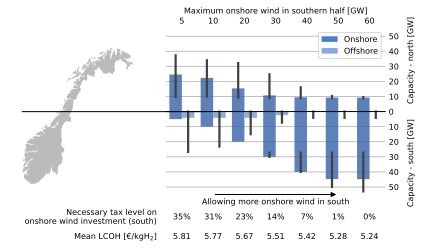

In [34]:
# Two subplots; one for the map and one for the barplot
fig, axs = plt.subplots(
    1,
    2,
    figsize=(16 * cm, 9 * cm),
    gridspec_kw={"width_ratios": [1, 1.2], "wspace": 0},
    layout="tight",
)

# First the data
ax = axs[1]

df = stats_long.loc[stats_long.lim <= 60]
df.loc[:, "p_nom"] /= 1e3

df_north = df.loc[df.gen.str.contains("north")]
df_south = df.loc[df.gen.str.contains("south")]
df_south.loc[:, "p_nom"] *= -1

# color_onwind = default_config["plotting"]["tech_colors"]["onwind"]
color_onwind = "#4f8ae8"

palette = {
    "onwind-north": default_config["plotting"]["tech_colors"]["onwind"],
    "onwind-south": default_config["plotting"]["tech_colors"]["onwind"],
    "offwind-north": default_config["plotting"]["tech_colors"]["offwind"],
    "offwind-south": default_config["plotting"]["tech_colors"]["offwind"],
}

args = dict(
    x="lim",
    y="p_nom",
    estimator="median",
    errorbar=("pi", 90),
    hue="gen",
    palette=palette,
    alpha=0.8,
    ax=ax,
    legend=False,
)
sns.barplot(data=df_north, **args)
sns.barplot(data=df_south, **args)

# Draw a black horizontal arrow below the bars; then place some text below the arrow
a_y = -55
ax.annotate(
    "",
    xy=(1, a_y),
    xytext=(5, a_y),
    arrowprops=dict(arrowstyle="<|-", color="black", linewidth=1),
)
ax.text(
    3,
    a_y - 5,
    "Allowing more onshore wind in south",
    ha="center",
    va="center",
    size=labelsize,
)

# Annotate each lower bar with the value (bold)
for i, (_, row) in enumerate(stats.groupby("lim").mean().iterrows()):
    ax.text(
        i,
        -70,
        f"{100 * row['tax']:.0f}%",
        ha="center",
        va="center",
        size=labelsize,
    )

    ax.text(
        i,
        -83,
        f"{row['H2 cost']:.2f}",
        ha="center",
        va="center",
        size=labelsize,
    )

# Label this row of text; use annotation function
ax.text(
    -0.8,
    -70,
    "Necessary tax level on\nonshore wind investment (south)",
    ha="right",
    va="center",
    size=labelsize,
)

ax.text(
    -0.8,
    -83,
    "Mean LCOH [€/kgH$_2$]",
    ha="right",
    va="center",
    size=labelsize,
)


# Turn of spines
for spine in ax.spines.values():
    spine.set_visible(False)

# y-lims
ax.set_ylim(-55, 55)

# Draw thick horizon black line at y=0
ax.axhline(0, color="black", linewidth=1, clip_on=False)

# Turn of tick marks
ax.tick_params(axis="both", which="both", length=0)

# Add y grid, set major ticks every 10
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(10))
ax.yaxis.grid(True)
# Display grid lines behind the bars
ax.set_axisbelow(True)

# Format y-tick marks as positive numbers
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, _: f"{abs(x):.0f}"))

# X-label; place on top
ax.set_xlabel("Maximum onshore wind in southern half [GW]", size=labelsize)
ax.xaxis.set_label_position("top")

# Alss x-ticks on top
ax.xaxis.tick_top()

# Two y-labels, one for positive and one for negative y
ax.set_ylabel(None)
ax.text(7.2, 5, "Capacity - north [GW]", va="bottom", rotation=90, size=labelsize)
ax.text(7.2, -5, "Capacity - south [GW]", va="top", rotation=90, size=labelsize)

# y-ticks on the right
ax.yaxis.tick_right()

# Set tick sizes
ax.tick_params(axis="both", which="both", labelsize=ticksize)

# Manually add legend with two patched, one for onshore and one for offshore
ax.legend(
    handles=[
        mpl.patches.Patch(
            facecolor=palette["onwind-north"], alpha=0.8, edgecolor="none", label="Onshore"
        ),
        mpl.patches.Patch(
            facecolor=palette["offwind-north"], alpha=0.8, edgecolor="none", label="Offshore"
        ),
    ],
    loc="upper right",
    fontsize=labelsize,
)


# Now plot a map of Norway on the left. First define orthographic projection centered on Norway
# proj = ccrs.Orthographic(central_longitude=15, central_latitude=65)
proj = ccrs.Sinusoidal(central_longitude=15)
axs[0] = plt.subplot(1, 2, 1, projection=proj)
ax = axs[0]

boundaries = [3, 27, 65 - 8, 65 + 8]
ax.set_extent(boundaries, crs=ccrs.PlateCarree())

shapename = "admin_0_countries"
countries_shp = shapereader.natural_earth(
    resolution="50m", category="cultural", name=shapename
)
countries = shapereader.Reader(countries_shp).records()
norway = [country for country in countries if country.attributes["NAME"] == "Norway"][0]
ax.add_geometries(
    [norway.geometry],
    ccrs.PlateCarree(),
    facecolor="#00000044",
    edgecolor="none",
    zorder=1,
)

# Remove spines
for spine in ax.spines.values():
    spine.set_visible(False)

# Draw thick line at 65N
ax.plot(
    [3, 45],
    [65, 65],
    transform=ccrs.PlateCarree(),
    color="black",
    linewidth=1,
    zorder=2,
    clip_on=False,
)

fig.tight_layout()

if save_figs:
    plt.savefig("figures/regional_variations.png", bbox_inches="tight", dpi=300)

plt.show()